/var/folders/dw/tdfx76710jg9qvmqz535zzhm0000gn/T/ipykernel_65670/1287667010.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm")
/var/folders/dw/tdfx76710jg9qvmqz535zzhm0000gn/T/ipykernel_65670/1287667010.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm")


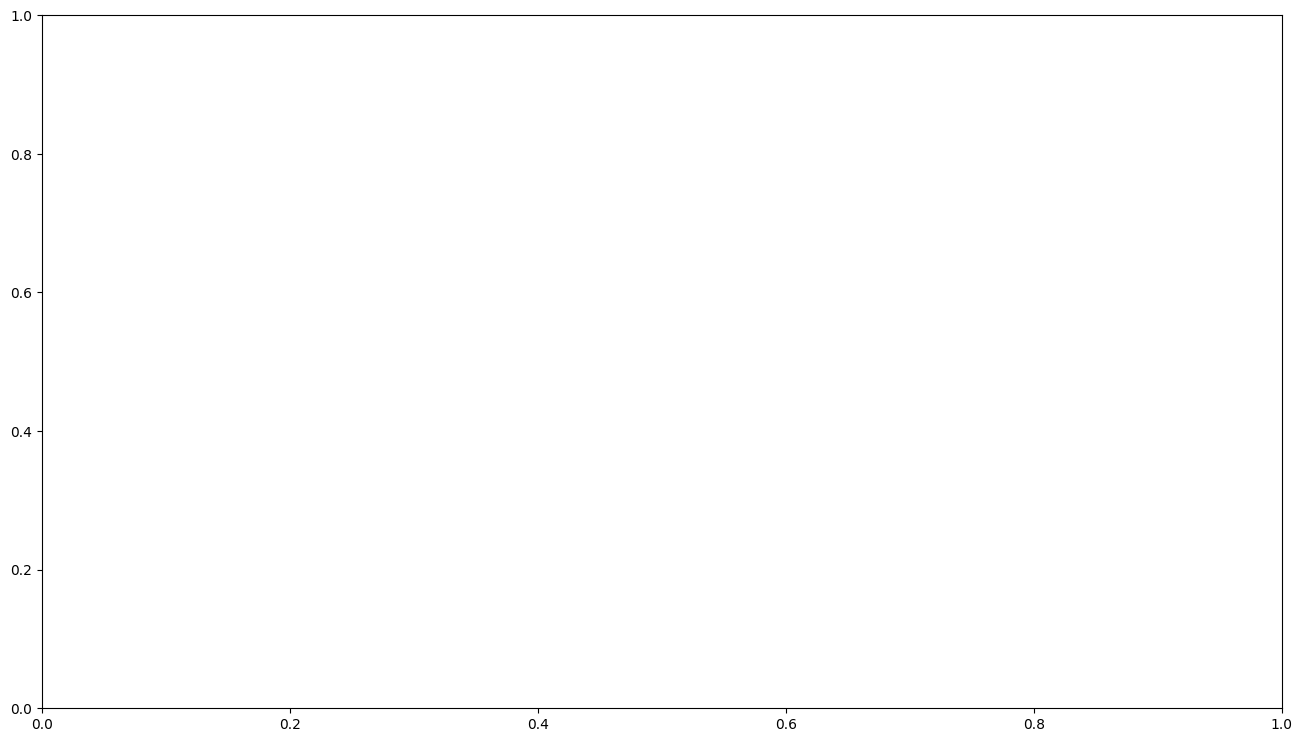

In [45]:
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    X_PIXELS,
    Y_PIXELS,
    extract_gaze_data_between_timestamps_proper,
    Events,
)
import json
import pandas as pd

fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))

ax.set_xlim(0, X_PIXELS)
ax.set_ylim(Y_PIXELS, 0)

EYE_TRACKER_FOLDER = "eye_tracker_data/"


# participants that were told that they can change the settings beforehand
participant_ids = [998]
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

for participant in participant_ids:
    for book in subquery.where(Events.event == "OPEN_BOOK"):
        START_TIME_BOOK = book.time
        END_TIME_BOOK = (
            subquery.where(Events.event == "CLOSE_BOOK")
            .where(Events.time > START_TIME_BOOK)
            .get()
            .time
        )

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK / 1000).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        with open(GAZE_FILE, "r") as f:
            GAZE_DATA_BOOK = extract_gaze_data_between_timestamps_proper(
                json.load(f), START_TIME_BOOK, END_TIME_BOOK
            )

        # Load into pandas dataframe
        df = pd.DataFrame(GAZE_DATA_BOOK)
        # The average pupil diameter is calculated as the average of the left and right pupil diameter
        # There can be None values in the pupil diameter, so we drop those
        df["pupil_diameter"] = df[["left_pupil_diameter", "right_pupil_diameter"]].mean(
            axis=1
        )
        # Calculate the rolling average
        df["pupil_diameter"] = df["pupil_diameter"].rolling(50).mean()
        df = df.dropna(subset=["pupil_diameter"])

        # Normalize the pupil diameter for use in the colour of the plot
        df["normalized_pupil_diameter"] = (
            df["pupil_diameter"] - df["pupil_diameter"].min()
        ) / (df["pupil_diameter"].max() - df["pupil_diameter"].min())

        # Plot the gaze data

        # Get the events that have a timestamp less than the first CLOSE_BOOK event
        events_book = subquery.where(Events.time < END_TIME_BOOK)

        for page in subquery.where(Events.event == "NEXT_PAGE").where(
            Events.time > START_TIME_BOOK
        ):
            START_TIME_PAGE = page.time
            end_page = (
                events_book.where(Events.event == "NEXT_PAGE")
                .where(Events.time > START_TIME_PAGE)
                .get_or_none()
            )
            if end_page is None:
                continue
            END_TIME_PAGE = end_page.time

            # Get the image to display on the plot
            page.screenshot_file

            # Get the gaze data for the page
            GAZE_DATA_PAGE = extract_gaze_data_between_timestamps_proper(
                GAZE_DATA_BOOK, START_TIME_PAGE, END_TIME_PAGE
            )
            df_page = pd.DataFrame(GAZE_DATA_PAGE)